<a href="https://colab.research.google.com/github/jo1jun/Transformer/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, device & dtype


In [80]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

% pip install einops

from einops import rearrange, repeat, reduce
# tensor 연산을 간편하게 하기 위해 einops moudule import.
# reference & tutorial : http://einops.rocks/pytorch-examples.html

# Multi Head Attention Layer

In [81]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout_ratio):
        super().__init__()

        self.d_model = d_model # embed dimension
        self.nhead = nhead # head 수
        self.head_dim = d_model // nhead # head 마다의 dimension

        # paper 보면 d_model * d_k 이런 shape 인데, 실제 구현에서는 d_model * d_model 하고 나온 것을 쪼개서 multi head self attention 에 들어가게 함.
        self.qLinear = nn.Linear(d_model, d_model) # query lineqr
        self.kLinear = nn.Linear(d_model, d_model) # key linear
        self.vLinear = nn.Linear(d_model, d_model) # value linear
        self.oLinear = nn.Linear(d_model, d_model) # output linear

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]
        query_len = query.shape[1]
        value_len = key_len = key.shape[1]

        # query: [batch_size, query_len, d_model]
        # key: [batch_size, key_len, d_model]
        # value: [batch_size, value_len, d_model]
 
        Q = self.qLinear(query)
        K = self.kLinear(key)
        V = self.vLinear(value)

        # Q: [batch_size, query_len, d_model]
        # K: [batch_size, key_len, d_model]
        # V: [batch_size, value_len, d_model]

        # d_model = nhead * head_dim
        # head 수로 distribute
        Q = rearrange(Q, 'b l (h d) -> b h l d', h=self.nhead)
        K = rearrange(K, 'b l (h d) -> b h l d', h=self.nhead)
        V = rearrange(V, 'b l (h d) -> b h l d', h=self.nhead)

        # Q: [batch_size, nhead, query_len, head_dim]
        # K: [batch_size, nhead, key_len, head_dim]
        # V: [batch_size, nhead, value_len, head_dim]

        # attention weight 계산
        weight = torch.matmul(Q, rearrange(K, 'b h l d -> b h d l')) / np.sqrt(self.head_dim)

        # weight: [batch_size, nhead, query_len, key_len]

        if mask is not None:
            # mask 가 true 면 -1e9로 하여 softmax 값 0으로.
            weight = weight.masked_fill(mask, -1e9)

        attention = torch.softmax(weight, dim=-1) # TODO : softmax -1?

        # attention: [batch_size, nhead, query_len, key_len]

        # context vector 계산
        c = torch.matmul(self.dropout(attention), V)

        # c: [batch_size, nhead, query_len, head_dim]

        # reshape & concat
        c = rearrange(c, 'b h l d -> b l (h d)')

        # c: [batch_size, query_len, d_model]

        output = self.oLinear(c)

        # output: [batch_size, query_len, d_model]

        return output, attention

# Position-wise Feed Forward Layer

In [82]:
class PositionWiseFeedForwardLayer(nn.Module):
    def __init__(self, d_model, ff_dim, dropout_ratio):
        super().__init__()

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.linear2 = nn.Linear(ff_dim, d_model)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, d_model]

        x = self.dropout(torch.relu(self.linear1(x)))

        # x: [batch_size, seq_len, ff_dim]

        x = self.linear2(x)

        # x: [batch_size, seq_len, d_model]

        return x

# Encoder Layer

In [83]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.layerNorm1 = nn.LayerNorm(d_model)
        self.layerNorm2 = nn.LayerNorm(d_model)
        self.multiHeadAttentionLayer = MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.positionWiseFeedForward = PositionWiseFeedForwardLayer(d_model, ff_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len, d_model]
        # src_mask: [batch_size, src_len]

        # self attention 이므로 query, key, value 전부 동일
        _src, _ = self.multiHeadAttentionLayer(src, src, src, src_mask)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        src = self.layerNorm1(src + self.dropout(_src))

        # src: [batch_size, src_len, d_model]

        _src = self.positionWiseFeedForward(src)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        src = self.layerNorm2(src + self.dropout(_src))

        # src: [batch_size, src_len, d_model]

        return src

# Encoder

In [84]:
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()

        # EncoderLayer 을 n_layers 만큼 반복.
        self.layers = nn.ModuleList([EncoderLayer(d_model, nhead, ff_dim, dropout_ratio) for _ in range(n_layers)])

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, d_model]

        return src

# Decoder Layer

In [85]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.layerNorm1 = nn.LayerNorm(d_model)
        self.layerNorm2 = nn.LayerNorm(d_model)
        self.layerNorm3 = nn.LayerNorm(d_model)
        self.multiHeadAttentionLayer1 = MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.multiHeadAttentionLayer2= MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.positionWiseFeedForward = PositionWiseFeedForwardLayer(d_model, ff_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, tgt, enc_src, tgt_mask, src_mask):

        # tgt: [batch_size, tgt_len, d_model]
        # enc_src: [batch_size, src_len, d_model]
        # tgt_mask: [batch_size, tgt_len]
        # src_mask: [batch_size, src_len]

        # self attention
        _tgt, _ = self.multiHeadAttentionLayer1(tgt, tgt, tgt, tgt_mask)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        tgt = self.layerNorm1(tgt + self.dropout(_tgt))

        # tgt: [batch_size, tgt_len, d_model]

        # encoder attention
        # decoder 의 query, encdoer 의 key, value 로 attention
        _tgt, attention = self.multiHeadAttentionLayer2(tgt, enc_src, enc_src, src_mask)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        tgt = self.layerNorm2(tgt + self.dropout(_tgt))

        # tgt: [batch_size, tgt_len, d_model]

        # positionwise feedforward
        _tgt = self.positionWiseFeedForward(tgt)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        tgt = self.layerNorm3(tgt + self.dropout(_tgt))

        # tgt: [batch_size, tgt_len, d_model]
        # attention: [batch_size, nhead, tgt_len, src_len]

        return tgt, attention

# Decoder

In [86]:
class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.layers = nn.ModuleList([DecoderLayer(d_model, nhead, ff_dim, dropout_ratio) for _ in range(n_layers)])

        self.fc_out = nn.Linear(d_model, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, tgt, enc_src, tgt_mask, src_mask):

        # tgt: [batch_size, tgt_len]
        # enc_src: [batch_size, src_len, d_model]
        # tgt_mask: [batch_size, tgt_len]
        # src_mask: [batch_size, src_len]

        batch_size = tgt.shape[0]
        tgt_len = tgt.shape[1]

        # tgt: [batch_size, tgt_len, d_model]

        for layer in self.layers:
            tgt, attention = layer(tgt, enc_src, tgt_mask, src_mask)

        # tgt: [batch_size, tgt_len, d_model]
        # attention: [batch_size, nhead, tgt_len, src_len]

        output = self.fc_out(tgt)

        # output: [batch_size, tgt_len, output_dim]

        return output, attention

# Token & Positional Embedding

In [87]:
class TokPosEmbedding(nn.Module):
  def __init__(self, input_dim, d_model, dropout_ratio):
    super().__init__()
    self.tokEmbedding = nn.Embedding(input_dim, d_model)
    self.posEmbedding = nn.Embedding(100, d_model) # 위치 임베딩을 고정 함수가 아니라 학습하는 형태로 구현.
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, src):
    batch_size = src.shape[0]
    src_len = src.shape[1]

    # 0 ~ src_len 등차 수열값 을 bactch 한개와 동일한 shape으로 생성 (positional embedding)
    pos = torch.arange(0, src_len, dtype=dtype) # pos: [src_len]
    pos = repeat(pos, 'l -> b l', b=batch_size).to(device) # pos: [batch_size, src_len]

    src = self.dropout((self.tokEmbedding(src) * np.sqrt(self.d_model)) + self.posEmbedding(pos))

    # src: [batch_size, src_len, d_model]

    return src

# Transformer

In [88]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.encEmbedding = TokPosEmbedding(input_dim, d_model, dropout_ratio)
        self.encoder = Encoder(input_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio)
        self.decEmbedding = TokPosEmbedding(output_dim, d_model, dropout_ratio)
        self.decoder = Decoder(output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio)

    def make_src_mask(self, src, pad):

        # src: [batch_size, src_len]

        # pad mask
        src_mask = (src.data.eq(pad)).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]
        return src_mask

    def make_tgt_mask(self, tgt, pad):
        
        # tgt: [batch_size, tgt_len]

        tgt_pad_mask = (tgt.data.eq(pad)).unsqueeze(1).unsqueeze(2)

        # tgt_pad_mask: [batch_size, 1, 1, tgt_len]

        tgt_len = tgt.shape[1]

        # chitting 방지 mask
        tgt_sub_mask = torch.triu(torch.ones((tgt_len, tgt_len))).bool().to(device)

        # tgt_sub_mask: [tgt_len, tgt_len] (upper triangular square matrix 형태)

        # mask 값이 true 면 fill 할 것이므로 pad_mask 와 or 연산.
        tgt_mask = tgt_pad_mask | tgt_sub_mask

        # tgt_mask: [batch_size, 1, tgt_len, tgt_len]

        return tgt_mask

    def forward(self, src, tgt, pad):

        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]

        src_mask = self.make_src_mask(src, pad)
        tgt_mask = self.make_tgt_mask(tgt, pad)

        # src_mask: [batch_size, 1, 1, src_len]
        # tgt_mask: [batch_size, 1, tgt_len, tgt_len]

        src = self.encEmbedding(src)
        tgt = self.decEmbedding(tgt)

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, d_model]

        output, attention = self.decoder(tgt, enc_src, tgt_mask, src_mask)

        # output: [batch_size, tgt_len, output_dim]
        # attention: [batch_size, nhead, tgt_len, src_len]

        return output, attention

    def generate(self, src, start_id, sample_size, pad):

        batch_size = src.shape[0]

        src_mask = self.make_src_mask(src, pad)
        src = self.encEmbedding(src)
        enc_src = self.encoder(src, src_mask)
      
        sampled_tensor = torch.tensor([start_id], dtype=dtype)
        # sampled_tensor: [1]

        sampled_tensor = repeat(sampled_tensor, 's -> b s', b=batch_size).to(device)
        # sampled_tensor: [batch_size, 1]

        for _ in range(sample_size):

          tgt_mask = self.make_tgt_mask(sampled_tensor, pad)
          tgt = self.decEmbedding(sampled_tensor)
          probabilities, attention = self.decoder(tgt, enc_src, tgt_mask, src_mask)

          pred_token = probabilities.argmax(2)[:,-1].unsqueeze(1)

          sampled_tensor = torch.cat((sampled_tensor, pred_token), 1) # pred sentence 에 concat

        return sampled_tensor, attention


# Date format Dataset

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import os
os.chdir('/content/drive/MyDrive/dataset')
import sequence

# google mount 한 뒤 '/content/drive/MyDrive/' 에 dataset 저장 후 실행.

(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
# char -> id & id -> char dictionary
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)
print()

# 이미 id 화 되어있다.
print('question(id) : ', x_train[0])
print('correct(id)  : ',t_train[0])
print()

# sequence 확인 # ' ' : pad, '_' : start_char
print('question(char) : ', ' '.join([id_to_char[int(c)] for c in x_train[0]]))
print('correct(char)  : ', ' '.join([id_to_char[int(c)] for c in t_train[0]]))

vocab_size = len(char_to_id)
x_train = torch.tensor(x_train, dtype=dtype)
t_train = torch.tensor(t_train, dtype=dtype)
x_test = torch.tensor(x_test, dtype=dtype)
t_test = torch.tensor(t_test, dtype=dtype)
pad = 7 # pad token

(45000, 29)
(45000, 11)
(5000, 29)
(5000, 11)

question(id) :  [ 8 22  9 22  9  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7]
correct(id)  :  [14 11 12  9  8 15 16  8 15 16  9]

question(char) :  2 / 7 / 7 2                                              
correct(char)  :  _ 1 9 7 2 - 0 2 - 0 7


# hyperparameter

In [91]:
batch_size = 128
epoch = 20
input_dim = output_dim = vocab_size
d_model = 32
n_layers = 1
nhead = 2
ff_dim = 1024
dropout_ratio = 0.1
learning_rate = 0.0025

In [92]:
model = Transformer(input_dim, output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio)

In [93]:
import torch.optim as optim

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

criterion = nn.CrossEntropyLoss()

# Loader

In [94]:
from torch.utils.data import DataLoader

loader_x_train = DataLoader(x_train, batch_size=batch_size)
loader_t_train = DataLoader(t_train, batch_size=batch_size)
loader_x_test = DataLoader(x_test, batch_size=batch_size)
loader_t_test = DataLoader(t_test, batch_size=batch_size)

# Trainer

In [95]:
def trainer(model, optimizer, epochs, pad):

    pad = torch.tensor([pad], dtype=dtype).to(device)

    model.train()
    model = model.to(device)
    for e in range(epochs):
        for iters, (batch_x, batch_t) in enumerate(zip(loader_x_train, loader_t_train)):

            batch_x = batch_x.to(device)
            batch_t = batch_t.to(device)

            # correct 값의 마지막 원소 배제 (end token 없음. 마지막 원소 다음 token 학습할 필요 x)
            scores, _ = model(batch_x, batch_t[:, :-1], pad)

            # scores: [batch_size, tgt_len - 1, output_dim]

            scores = rearrange(scores, 'b l d -> (b l) d')

            # batch_t: [batch_size, tgt_len]
            
            # correct 값의 첫 원소 배제
            batch_t = rearrange(batch_t[:, 1:], 'b l -> (b l)')

            # scores  : [batch_size * tgt_len - 1, output_dim]
            # batch_t : [batch_size * tgt_len - 1]

            loss = criterion(scores, batch_t)

            optimizer.zero_grad()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0) # gradient clippling

            optimizer.step()

            if iters % 100 == 0:
                print('epoch[%d/%d] loss = %.4f' % (e+1, epochs, loss.item()))

# Train

In [96]:
trainer(model, optimizer, epoch, pad)

epoch[1/20] loss = 4.2828
epoch[1/20] loss = 0.9526
epoch[1/20] loss = 0.6326
epoch[1/20] loss = 0.4389
epoch[2/20] loss = 0.4055
epoch[2/20] loss = 0.3299
epoch[2/20] loss = 0.2488
epoch[2/20] loss = 0.2160
epoch[3/20] loss = 0.1821
epoch[3/20] loss = 0.1946
epoch[3/20] loss = 0.1521
epoch[3/20] loss = 0.1483
epoch[4/20] loss = 0.1171
epoch[4/20] loss = 0.1342
epoch[4/20] loss = 0.1111
epoch[4/20] loss = 0.0978
epoch[5/20] loss = 0.0939
epoch[5/20] loss = 0.1019
epoch[5/20] loss = 0.0985
epoch[5/20] loss = 0.0779
epoch[6/20] loss = 0.0683
epoch[6/20] loss = 0.0921
epoch[6/20] loss = 0.1049
epoch[6/20] loss = 0.0897
epoch[7/20] loss = 0.0686
epoch[7/20] loss = 0.0935
epoch[7/20] loss = 0.0782
epoch[7/20] loss = 0.0702
epoch[8/20] loss = 0.0510
epoch[8/20] loss = 0.0744
epoch[8/20] loss = 0.0623
epoch[8/20] loss = 0.0628
epoch[9/20] loss = 0.0528
epoch[9/20] loss = 0.0506
epoch[9/20] loss = 0.0561
epoch[9/20] loss = 0.0628
epoch[10/20] loss = 0.0635
epoch[10/20] loss = 0.0709
epoch[10/2

# Checker

In [101]:
def checker(loader_x, loader_t, model, pad):

    pad = torch.tensor([pad], dtype=dtype).to(device)

    model.eval()
    with torch.no_grad():
      correct_num = 0
      for iters, (batch_x, batch_t) in enumerate(zip(loader_x, loader_t)):

        batch_x = batch_x.to(device)
        batch_t = batch_t.to(device)

        start_id = batch_t[0,0]
        correct = batch_t[:,1:]

        predict, _ = model.generate(batch_x, start_id, correct.shape[1], pad)
        predict = predict[:,1:]

        correct_num += (predict == correct).sum()
        
    return correct_num

# Accuracy

In [102]:
correct_num = checker(loader_x_train, loader_t_train, model, pad)
acc = float(correct_num) / (t_train.shape[0] * (t_train.shape[1] - 1))
print('train accuracy %.3f%%' % (acc * 100))

correct_num = checker(loader_x_test, loader_t_test,model, pad)
acc = float(correct_num) / (t_test.shape[0] * (t_test.shape[1] - 1))
print('test accuracy %.3f%%' % (acc * 100))

train accuracy 98.902%
test accuracy 98.816%


# Visualizing Attention

In [103]:
def visualize(attention_map, row_labels, column_labels):
    fig = plt.figure(figsize=(20,5))
    h = attention_map.shape[0]
    for i, attention in enumerate(attention_map):
      ax = fig.add_subplot(1, h, i+1)
      ax.pcolor(attention, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

      ax.patch.set_facecolor('black')
      ax.set_yticks(np.arange(attention.shape[0])+0.5, minor=False)
      ax.set_xticks(np.arange(attention.shape[1])+0.5, minor=False)
      ax.invert_yaxis()
      ax.set_xticklabels(row_labels, minor=False)
      ax.set_yticklabels(column_labels, minor=False)

    plt.show()

## (x, y) = (question, predict X nhead)
### 학습 후 반복적으로 실행시켜 attention 이 잘 작동하는 것을 확인할 수 있다.
### 가로 축 2개 head 마다의 attention, 세로 축으로 5개의 sample.

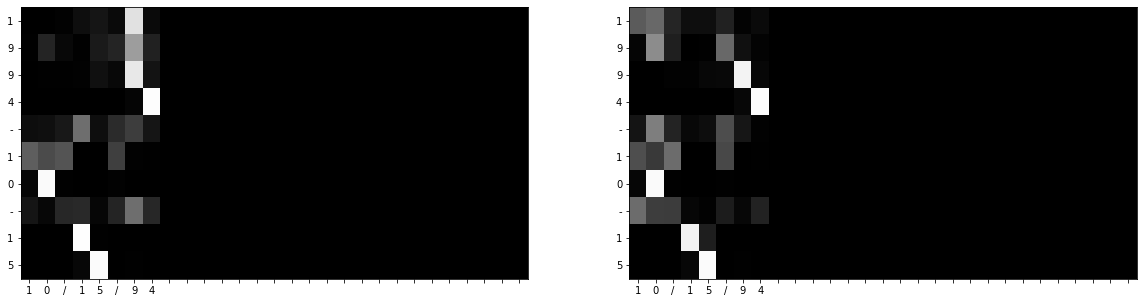

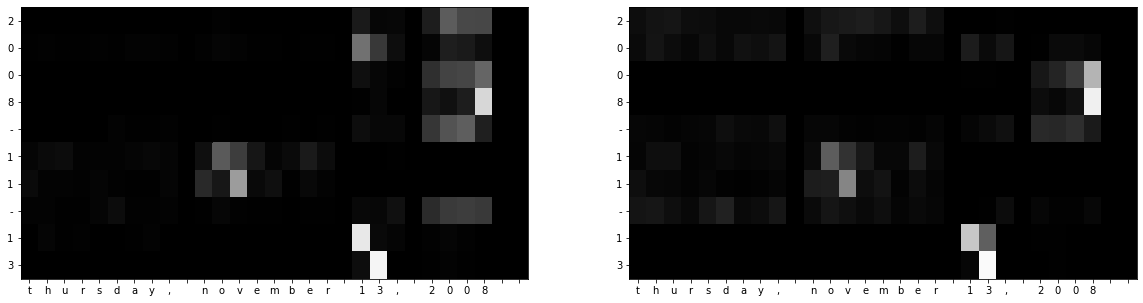

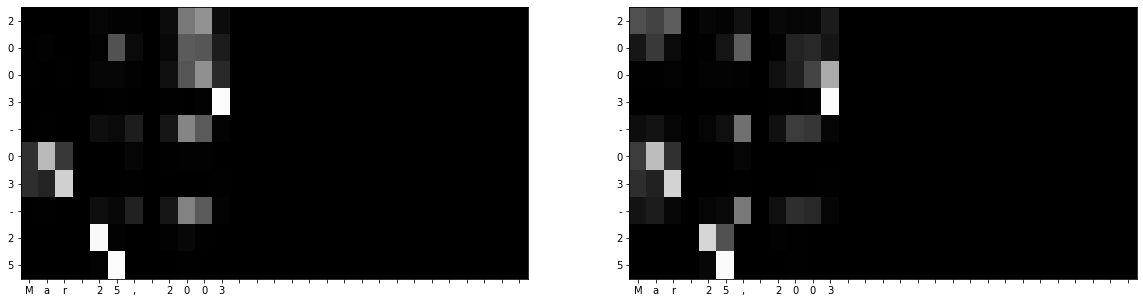

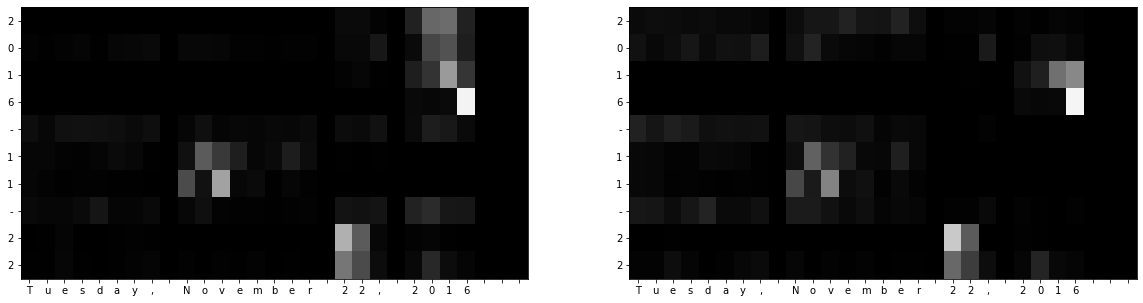

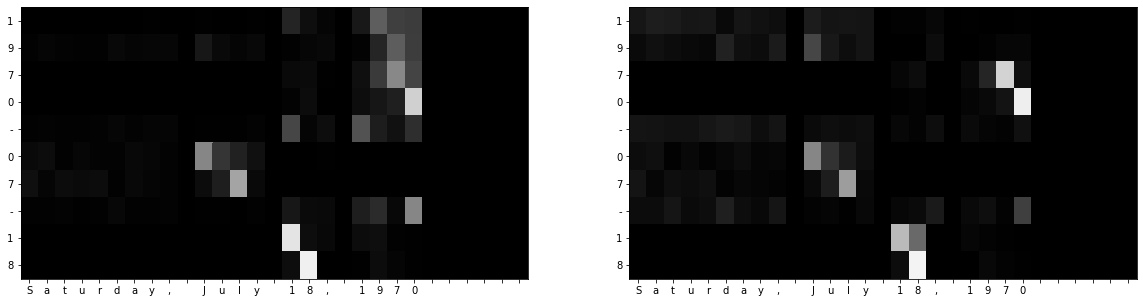

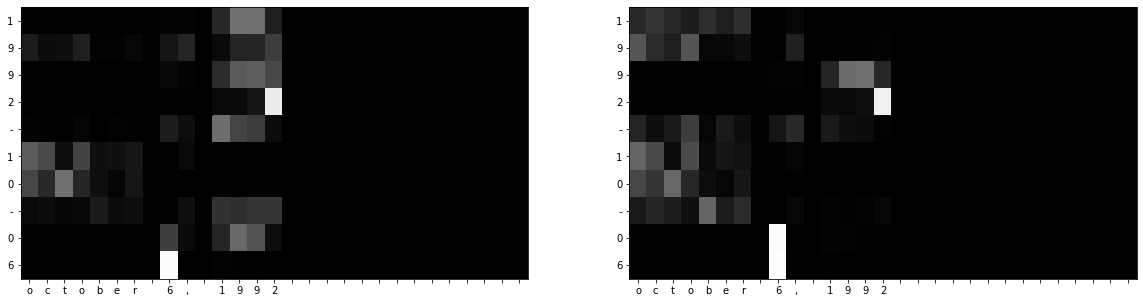

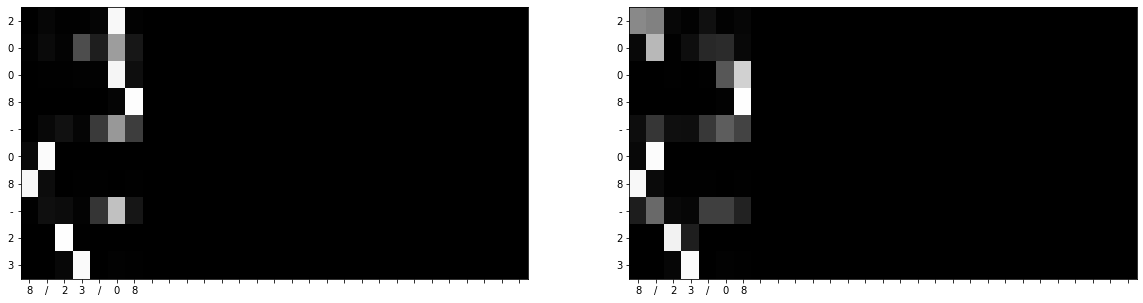

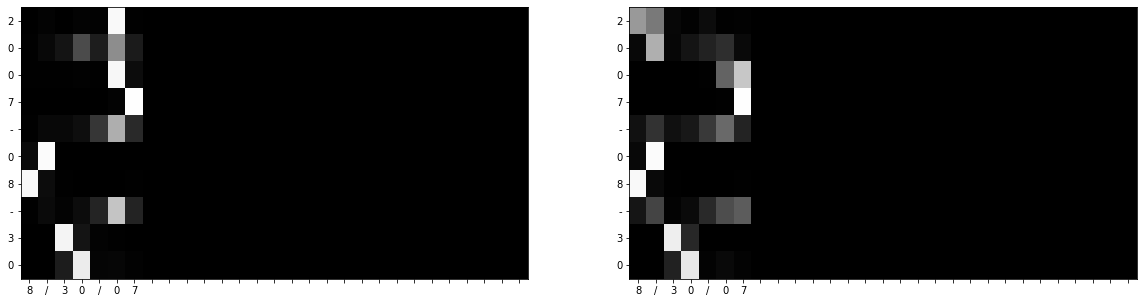

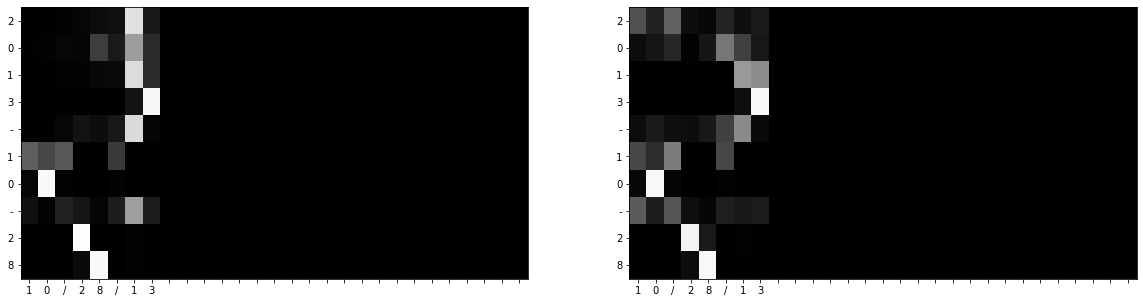

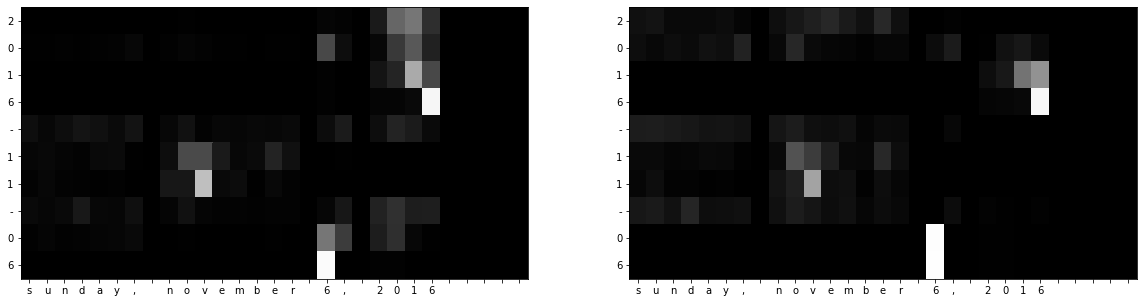

In [104]:
for i in range(10):
  idx = [i]

  question = x_test[idx].to(device)
  correct = t_test[idx].to(device)
  pad = torch.tensor([pad], dtype=dtype).to(device)

  correct = correct.flatten()
  # 머릿글자
  start_id = correct[0]

  correct = correct[1:]
  with torch.no_grad():
    predict, attention  = model.generate(question, start_id, len(correct), pad)
  predict = predict[:,1:]

  # 문자열로 변환
  question = [id_to_char[int(c)] for c in question.flatten()]
  correct = [id_to_char[int(c)] for c in correct.flatten()]
  predict = [id_to_char[int(c)] for c in predict.flatten()]

  visualize(attention.squeeze(0).cpu().numpy(), question, predict)